In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re

In [78]:
result_dir = '../results/FP_Truthful_Oracle_sigmoids_linucb_mulruns_local/'

In [79]:
# Load the results
files_to_read = [file for file in os.listdir(result_dir) if file.endswith('.csv')]

In [80]:
results = pd.concat([pd.read_csv(result_dir + file) for file in files_to_read if file.startswith('agent_stats')])

In [81]:
# Prima raggruppo per Run e Iteration per avere il dato aggregato per ogni iterazione
grouped_results_run_iter = results.groupby(['Run', 'Iteration']) \
    .agg({'clicks': 'sum', 'impressions': 'sum', 'true_clicks':'sum', 'exp_rew':'sum'}) \
    .reset_index()

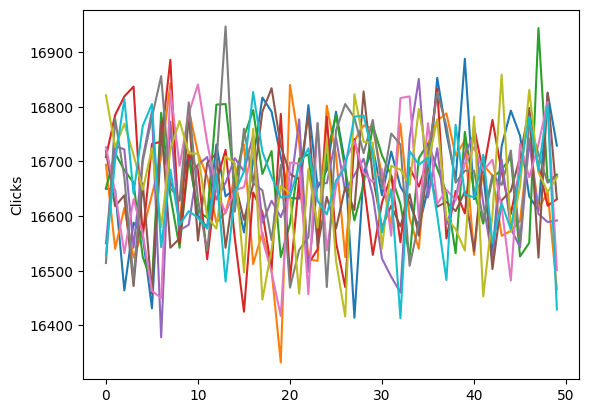

In [82]:
runs = grouped_results_run_iter['Run'].unique()
for run in runs:
    curr_run = grouped_results_run_iter[grouped_results_run_iter['Run'] == run]
    plt.plot(curr_run['Iteration'].to_numpy(), curr_run['clicks'].to_numpy(), label=f'Run {run}')
plt.ylabel('Clicks')
plt.show()

In [83]:
grouped_results_iter = grouped_results_run_iter.groupby('Iteration').mean().reset_index()

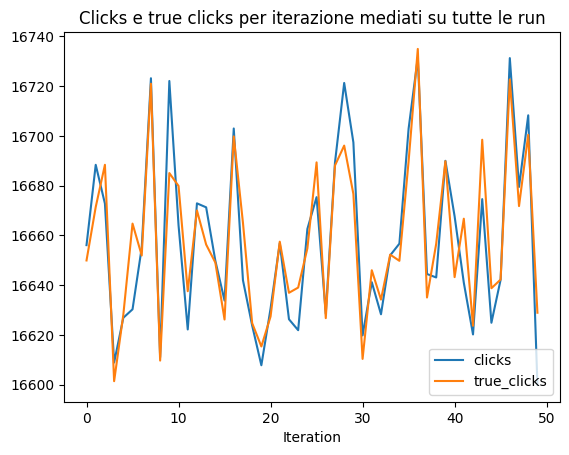

In [84]:
grouped_results_iter.plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run')
plt.show()

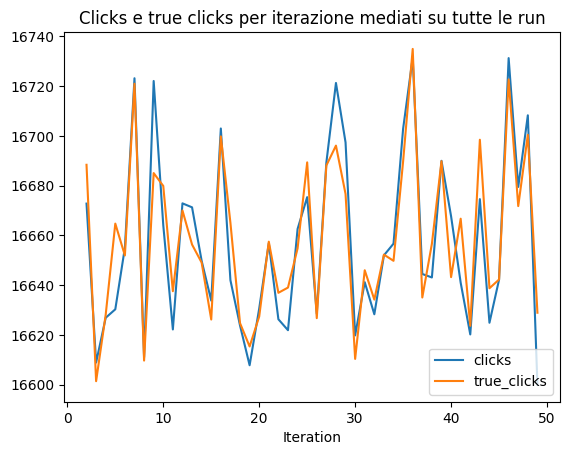

In [85]:
grouped_results_iter[grouped_results_iter['Iteration']>1].plot(x='Iteration', y=['clicks', 'true_clicks'], title='Clicks e true clicks per iterazione mediati su tutte le run')
plt.show()

In [86]:
grouped_results_iter['ctr'] = grouped_results_iter['clicks'] / grouped_results_iter['impressions']
grouped_results_iter['true_ctr'] = grouped_results_iter['true_clicks'] / grouped_results_iter['impressions']

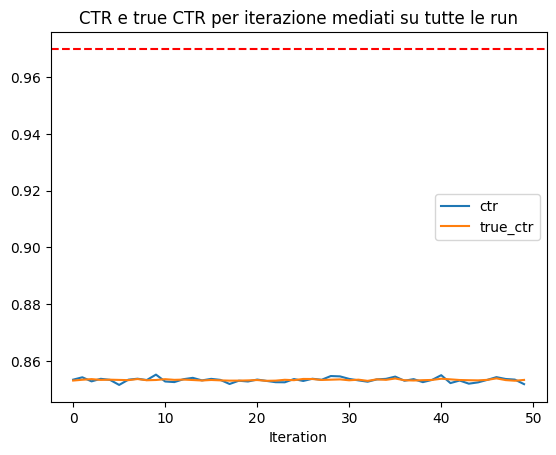

In [87]:
grouped_results_iter.plot(x='Iteration', y=['ctr', 'true_ctr'], title='CTR e true CTR per iterazione mediati su tutte le run')
plt.axhline(y=0.97, color='r', linestyle='--')
plt.show()